# ADVI - Automatic Differentiation VI

When the problem at hand is not from the exponential family (or a conjugate family) (SVI from [Stochastic Variational Inference, Hoffman 2013](https://www.jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf)) we have to rely on stochastic approaches.

[ADVI](https://arxiv.org/abs/1603.00788) is one such approach.


mean field gaussian cannot capture correlations
full rank gaussians can.

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions


#### Mean Field Variational Family - Gaussian (Is this assumed by mean field?)

In [7]:
# Target/True
true_mean = [0.3, 0.7]
true_cov = [[0.8, 0.3],
            [0.3, 1.8]]

target_distribution = tfd.MultivariateNormalFullCovariance(
    loc=true_mean,
    covariance_matrix=true_cov
)

def get_batch(n_samples=100):
    # placeholder batcher and dataloader
    return target_distribution.sample(n_samples)

## --- ADVI -----

# mean-field Gaussian distribution
q_mu = tf.Variable([0.0, 1.0], dtype=tf.float32, name='q_mu')
q_sigma = tfp.util.TransformedVariable([1.0,2.0], name='q_sigma', bijector=tfp.bijectors.Softplus())
q_distribution = tfd.MultivariateNormalDiag(loc=q_mu, scale_diag=q_sigma)

# Setup
n_steps = 1000
learning_rate = 0.1
reparam = True

optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer.build(q_distribution.trainable_variables)

for step in range(n_steps):
    with tf.GradientTape() as tape:

        batch = get_batch(n_samples=100)
        if reparam: # Very noticeable difference in performance.
            epsilon = tf.random.normal(shape=batch.shape, mean=0, stddev=1)
            batch = q_mu + epsilon * q_sigma
    
        kl_divergence = tfd.kl_divergence(q_distribution, target_distribution)#target_distribution
        elbo_loss = -tf.reduce_mean(q_distribution.log_prob(batch)) + kl_divergence
       

    # compute gradients and update the parameters
    gradients = tape.gradient(elbo_loss, q_distribution.trainable_variables)#[q_mu, q_sigma])
    optimizer.apply_gradients(zip(gradients, q_distribution.trainable_variables))

    if step % 100 == 0:
        print(f'step {step}, ELBO Loss: {elbo_loss.numpy()}')

print('Optimized q_mu:', q_mu.numpy())
print('Optimized q_sigma:', q_sigma.numpy())

step 0, ELBO Loss: 4.025396823883057
step 100, ELBO Loss: 2.1068038940429688
step 200, ELBO Loss: 2.207542657852173
step 300, ELBO Loss: 2.0791704654693604
step 400, ELBO Loss: 1.9602036476135254
step 500, ELBO Loss: 1.7990522384643555
step 600, ELBO Loss: 2.128545045852661
step 700, ELBO Loss: 1.9857897758483887
step 800, ELBO Loss: 2.085948944091797
step 900, ELBO Loss: 2.030101776123047
Optimized q_mu: [0.3 0.7]
Optimized q_sigma: [0.01689805 0.03148689]


Text(0.5, 1.0, 'Surrogate')

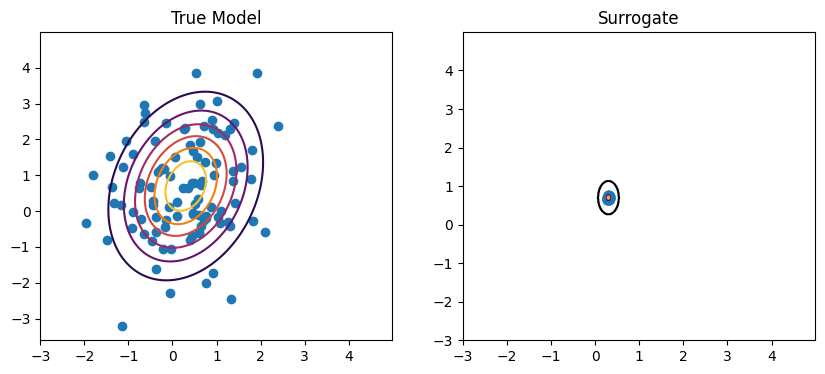

In [11]:
# Create True Model
# 2D Gaussian

def plot_dist(dist, ax, n_samples=None):

    if n_samples:
        x1,x2 = zip(*dist.sample(n_samples))
        ax.scatter(x1,x2)

    x1_mesh, x2_mesh = np.mgrid[-3:5:.01, -3:5:.01]
    pos = np.dstack((x1_mesh, x2_mesh))
    pdf = dist.prob(pos)

    ax.contour(x1_mesh, x2_mesh, pdf, cmap='inferno')#, cmap='viridis'


fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flat

plot_dist(target_distribution, axs[0], 100)
axs[0].set_title('True Model')

plot_dist(q_distribution, axs[1], 100)
axs[1].set_title('Surrogate')



In [12]:
print('Verify the bijector is working as expected:')
print(q_distribution.trainable_variables)

# Note
print(q_distribution.trainable_variables[1])
print(tfp.bijectors.Softplus()(q_distribution.trainable_variables[1]))

print(q_sigma) #last two are the same - ok it works as expected

Verify the bijector is working as expected:
(<tf.Variable 'q_mu:0' shape=(2,) dtype=float32, numpy=array([0.3, 0.7], dtype=float32)>, <tf.Variable 'q_sigma:0' shape=(2,) dtype=float32, numpy=array([-4.0720963, -3.4423993], dtype=float32)>)
<tf.Variable 'q_sigma:0' shape=(2,) dtype=float32, numpy=array([-4.0720963, -3.4423993], dtype=float32)>
tf.Tensor([0.01689805 0.03148689], shape=(2,), dtype=float32)
<TransformedVariable: dtype=float32, shape=[2], fn="softplus", numpy=array([0.01689805, 0.03148689], dtype=float32)>


# Some unfinished ideas

In [ ]:
"""
If the target distribution is unknown, you cannot directly compute the log probability. 
    In practice, you usually have access to samples from the target distribution and an 
    unnormalized log probability function, also known as the log joint probability,
    which includes the data likelihood and the prior probability.
"""

def log_joint_probability(theta, X):
    # The prior probability for theta
    prior = tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])
    log_prior = prior.log_prob(theta)

    # The likelihood of the data given theta
    likelihood = tfd.MultivariateNormalFullCovariance(loc=theta, covariance_matrix=true_cov)
    log_likelihood = tf.reduce_sum(likelihood.log_prob(X), axis=0)

    # The log joint probability
    return log_prior + log_likelihood

In [ ]:
# Since the target_distribution is unknown we need a prior??
prior_mean = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
prior_cov = tfd.WishartTriL(df=3, scale_tril=tf.linalg.cholesky([[1., 0.], [0., 1.]])) # This is a common prior for covariance


prior_mean = [0.0, 1.0]
prior_cov = [[1.0, 0.0],
            [0.0, 1.0]]
prior_dist = tfd.MultivariateNormalFullCovariance(
    loc=prior_mean,
    covariance_matrix=prior_cov
)
